# PID Implementation

following px4 ( https://docs.px4.io/master/en/config_mc/pid_tuning_guide_multicopter.html#rate-controller )

In [16]:
def clip(x, min_val, max_val):
    
    assert max_val > min_val
    
    if x > max_val:
        return max_val
    elif x < min_val:
        return min_val
    else:
        return x

class PID:
    def __init__(self, K: float, P: float, D: float, I: float, I_Limit: float = 15, doprint: bool = False):
        self.K = K
        self.P = P
        self.D = D
        self.I = I
        
        self.last_measurement = 0.0
        self.I_Value = 0.0
        self.I_Limit = I_Limit
        
        self.doprint = doprint
        
    def update(self, measurement: float, target: float, dt: float):
        
        # D - term
        if dt > 0.0:
            d_term = - self.D * (measurement - self.last_measurement)/dt
        else:
            d_term = 0.0
                  
        error = target - measurement
        
        # I - Term
        if self.I * abs(self.I_Value) < self.I_Limit and dt > 0.0:
            self.I_Value += error * dt
        
        self.I_Value = clip(self.I_Value, -self.I_Limit, self.I_Limit)
        
        output = d_term + self.I * self.I_Value + self.P * error
        
        if self.doprint:
            print(f"E: {error}, I: {self.I * self.I_Value}, D: {d_term}")
            
        self.insight = (self.I_Value, self.I, self.K * self.I * self.I_Value)
        
        self.last_measurement = measurement
        
        # apply K
        return self.K * output


In [17]:
import numpy as np

def Simulation(initial: float):
    
    value = initial
    
    def simulate(command: float, dt: float, doprint: bool = False):
        
        nonlocal value
        
        while dt > 0.0:
            value += 0.2 * command * dt
            
            if doprint:
                print(f"CMD: {command}, Value: {value}")
            
            return value
    
    return simulate

In [18]:
sim = Simulation(0.0)
sim(0.1, 0.1)

0.0020000000000000005

In [22]:
dt = 0.1
sim = Simulation(0.0)
pid = PID(5., 1.0, 0.2, 0.01, doprint=False)
cmd = 0.0

data = []

for i in range(3000):
    measurement = sim(cmd, dt)
    
    if i > 500:
        target = 1.0
    else:
        target = 0.0
    
    cmd = pid.update(measurement, target, dt)
    
    data.append((measurement, target, cmd, pid.I_Value))
    

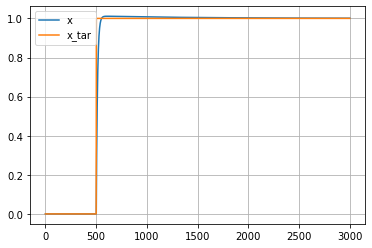

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

data = np.array(data)

plt.plot(data[:,0], label='x')
plt.plot(data[:,1], label='x_tar')

plt.grid()
plt.legend()

# Collect data for C implementation testing

In [25]:
pid.K, pid.P, pid.I, pid.D

(5.0, 1.0, 0.01, 0.2)

In [24]:
with open("../../lib/pid/test_pid_data.inc", "w") as afile:
    afile.write(f"const float test_data[{data.shape[0]}][{data.shape[1]}] = {{\n")
    for row in data:
        afile.write(("\t{{" + len(row)*"{:2.16f}f, " +"}},\n").format(*row))

    afile.write("};\n")
    